In [5]:
import argparse
import logging
import sys
import os
import random
import json
from pathlib import Path
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

#from model_robustness.attacks.networks import ResNet18, ConvNetLarge

ROOT = Path("")

In [26]:
df = pd.read_csv("../../data/soups/SVHN_hyp_10_f_results.csv", index_col=0)

In [27]:
data = pd.read_csv("../../data/all_results.csv")

In [28]:
data = data[data.dataset=="SVHN"]
data = data[data.attack=="PGD"]
data = data[data.setup=="hyp-10-f"]
data = data[data.eps==0.1]

data = data[["name", "dropout", "init_type", "nlin", "lr", "optimizer", "wd", "seed"]]

In [29]:
df = df.merge(data, on="name")

In [30]:
df["delta"] = df["normal_acc"] - df["soup_acc"]
df["delta_attack"] = df["normal_acc_attack"] - df["soup_acc_attack"]

In [31]:
df["indicator"] = (df.delta < 0).astype(int)
df["indicator_attack"] = (df.delta_attack < 0).astype(int)

In [32]:
top_20 = df.sort_values(by="delta", ascending=True)[:20]["name"].tolist()

In [33]:
df["top20"] = (df.name.isin(top_20))

In [34]:
df.head()

,name,normal_acc,normal_acc_attack,soup_acc,soup_acc_attack,dropout,init_type,nlin,lr,optimizer,wd,seed,delta,delta_attack,indicator,indicator_attack,top20
0,NN_tune_trainable_88eea_02041_2041_model::drop...,0.195,0.195874,0.195874,0.195874,0.3,uniform,sigmoid,0.0100,sgd,0.100,5,-0.000874,0.00000,1,0,False
1,NN_tune_trainable_88eea_01482_1482_model::drop...,0.732,0.438038,0.801782,0.467117,0.0,kaiming_uniform,gelu,0.0100,sgd,0.001,4,-0.069782,-0.02908,1,1,False
2,NN_tune_trainable_88eea_01552_1552_model::drop...,0.195,0.195874,0.195874,0.195874,0.3,normal,relu,0.0001,sgd,0.001,4,-0.000874,0.00000,1,0,False
3,NN_tune_trainable_88eea_03379_3379_model::drop...,0.195,0.195874,0.195874,0.195874,0.3,kaiming_uniform,relu,0.0010,sgd,0.100,8,-0.000874,0.00000,1,0,False
4,NN_tune_trainable_88eea_01709_1709_model::drop...,0.195,0.195874,0.195874,0.195874,0.5,normal,sigmoid,0.0001,sgd,0.100,4,-0.000874,0.00000,1,0,False


In [35]:
len(df)

4320

In [36]:
print(df.indicator.sum())
print(df.indicator_attack.sum())

4071
996


In [37]:
print(df.delta.mean())
print(df.delta_attack.mean())

-0.006592450175282842
-0.0024155099706344332


In [38]:
top_half_df = df[df.normal_acc >= df.normal_acc.mean()]
print(len(top_half_df))
print(f"mean = {df.normal_acc.mean()}")
print(top_half_df.indicator.sum())
print(top_half_df.indicator_attack.sum())

1280
mean = 0.34018125000000005
1077
917


In [39]:
print(top_half_df.delta.mean())
print(top_half_df.delta_attack.mean())

-0.01849567287377074
-0.0075872964044253225


In [40]:
top_quarter_df = df[df.normal_acc >= df.normal_acc.quantile(q=0.75)]
print(len(top_quarter_df))
print(f"75th percentile = {df.normal_acc.quantile(q=0.75)}")
print(top_quarter_df.indicator.sum())
print(top_quarter_df.indicator_attack.sum())

1080
75th percentile = 0.55325
936
827


In [41]:
print(top_quarter_df.delta.mean())
print(top_quarter_df.delta_attack.mean())

-0.0180942959093082
-0.009100551458034557


In [42]:
ninety_percentile_df = df[df.normal_acc >= df.normal_acc.quantile(q=0.9)]
print(len(ninety_percentile_df))
print(ninety_percentile_df.indicator.sum())
print(ninety_percentile_df.indicator_attack.sum())

432
416
350


In [43]:
print(ninety_percentile_df.delta.mean())
print(ninety_percentile_df.delta_attack.mean())

-0.008434969638507591
-0.005289519025017644


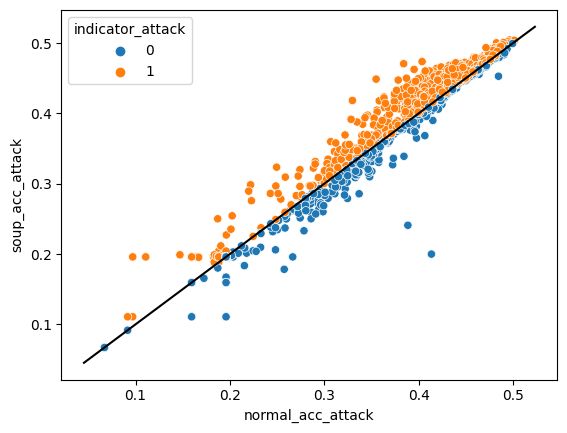

In [46]:
g = sns.scatterplot(df, x="normal_acc_attack", y="soup_acc_attack", hue="indicator_attack")
# Draw a line of x=y 
x0, x1 = g.get_xlim()
y0, y1 = g.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.plot(lims, lims, '-k')
plt.show()

In [213]:
df[df.top20]

,name,normal_acc,normal_acc_attack,soup_acc,soup_acc_attack,dropout,init_type,nlin,lr,optimizer,wd,delta,delta_attack,indicator,indicator_attack,top20
14,NN_tune_trainable_143c9_00428_428_model::dropo...,0.609,0.2867,0.6628,0.2835,0.0,kaiming_uniform,relu,0.001,sgd,0.010,-0.0538,0.0032,1,0,True
59,NN_tune_trainable_143c9_00684_684_model::dropo...,0.600,0.2867,0.6529,0.3041,0.0,kaiming_uniform,relu,0.001,sgd,0.010,-0.0529,-0.0174,1,1,True
64,NN_tune_trainable_143c9_00782_782_model::dropo...,0.560,0.2483,0.6195,0.2655,0.0,kaiming_normal,relu,0.001,adam,0.010,-0.0595,-0.0172,1,1,True
311,NN_tune_trainable_143c9_00214_214_model::dropo...,0.554,0.2426,0.6070,0.2613,0.0,kaiming_normal,sigmoid,0.001,adam,0.001,-0.0530,-0.0187,1,1,True
373,NN_tune_trainable_143c9_00012_12_model::dropou...,0.553,0.2468,0.6122,0.2616,0.0,kaiming_uniform,relu,0.001,adam,0.010,-0.0592,-0.0148,1,1,True
401,NN_tune_trainable_143c9_00142_142_model::dropo...,0.577,0.2528,0.6319,0.2736,0.0,kaiming_normal,relu,0.001,adam,0.010,-0.0549,-0.0208,1,1,True
511,NN_tune_trainable_143c9_00866_866_model::dropo...,0.551,0.2238,0.6041,0.2307,0.0,normal,tanh,0.001,sgd,0.001,-0.0531,-0.0069,1,1,True
598,NN_tune_trainable_143c9_00556_556_model::dropo...,0.603,0.2807,0.6544,0.2893,0.0,kaiming_uniform,relu,0.001,sgd,0.010,-0.0514,-0.0086,1,1,True
674,NN_tune_trainable_143c9_00596_596_model::dropo...,0.553,0.2507,0.6104,0.2722,0.0,kaiming_uniform,sigmoid,0.001,adam,0.001,-0.0574,-0.0215,1,1,True
727,NN_tune_trainable_143c9_00030_30_model::dropou...,0.567,0.2595,0.6218,0.2758,0.0,kaiming_normal,gelu,0.001,adam,0.010,-0.0548,-0.0163,1,1,True


In [210]:
only_tanh = df[df.nlin=="tanh"]

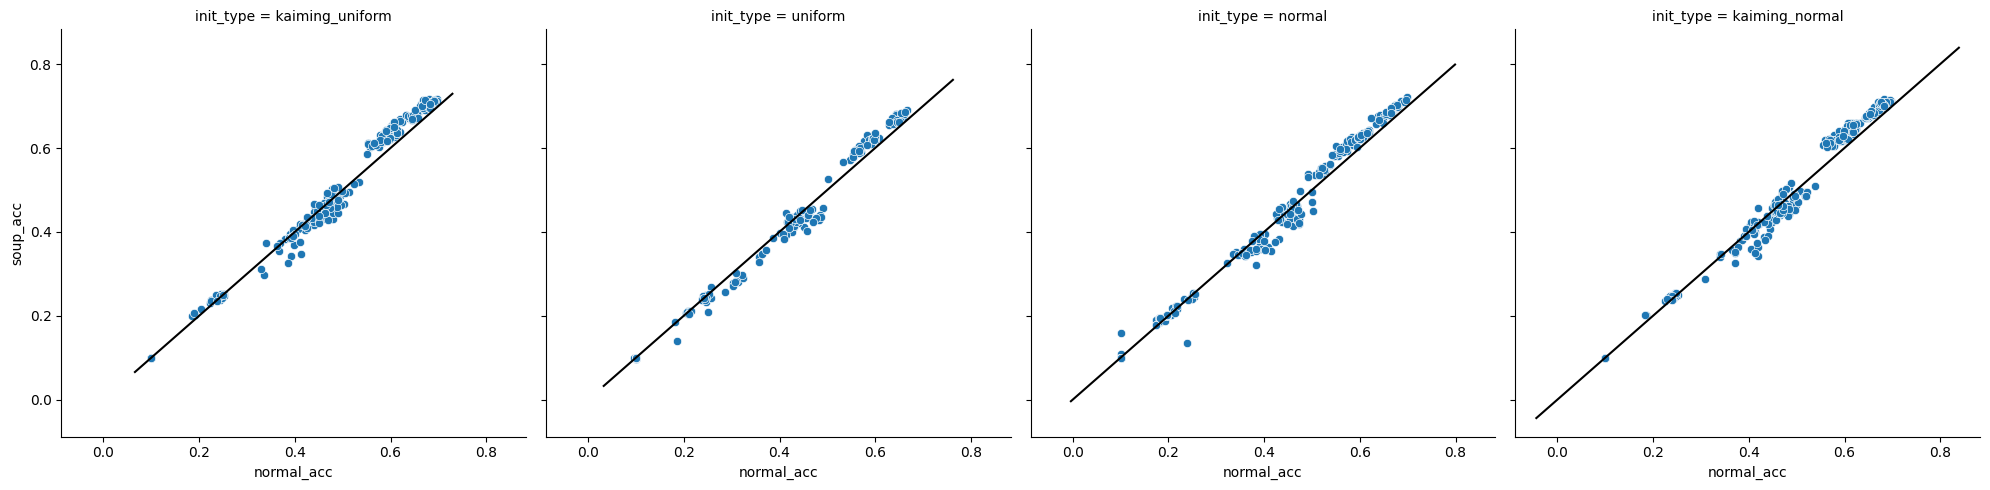

In [249]:
sns.color_palette("tab10")
g = sns.relplot(
    data=df,
    x="normal_acc",
    y="soup_acc",
    #hue="wd",
    #style="optimizer",
    col="init_type",
    #palette="tab10"
)
for i in range(len(g.axes[0])):
    x0, x1 = g.axes[0][i].get_xlim()
    y0, y1 = g.axes[0][i].get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.axes[0][i].plot(lims, lims, '-k')

plt.show()

In [198]:
for i in range(4):
    x0, x1 = g.axes[0][i].get_xlim()
    y0, y1 = g.axes[0][i].get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.axes[0][i].plot(lims, lims, '-k')
plt.show()

In [196]:
dir(g.axes[0][0])

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spine

<Axes: ylabel='Count'>

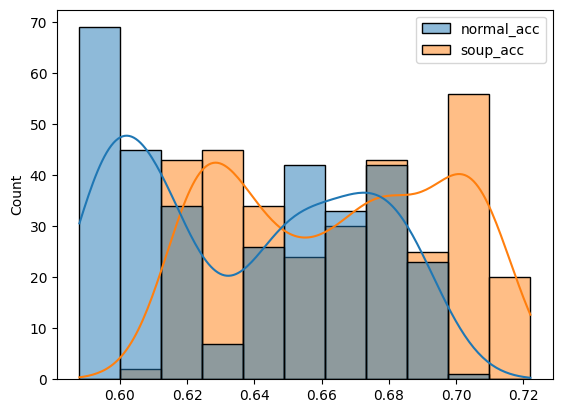

In [32]:
sns.histplot(best_df[["normal_acc", "soup_acc"]], kde=True)

<Axes: ylabel='Count'>

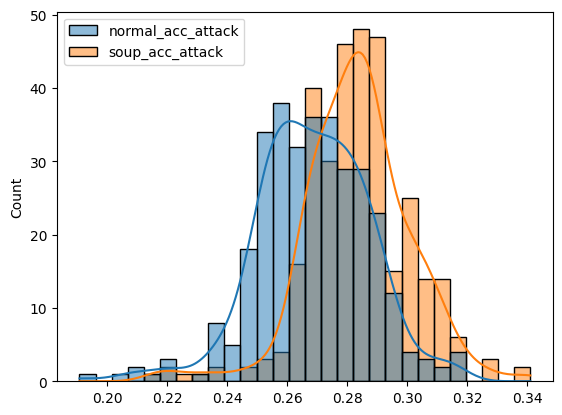

In [33]:
sns.histplot(best_df[["normal_acc_attack", "soup_acc_attack"]], kde=True)

In [60]:
path = os.path.join(ROOT, "/netscratch2/jlautz/model_robustness/src/model_robustness/data/sparsified/MNIST/PGD/hyp-10-r/model_list.txt")
with open(path, "r") as items:
    l = items.readlines()
    
    for i, j in enumerate(l):
        l[i] = j.replace("\n", "")

In [61]:
l[0]

'NN_tune_trainable_from_checkpoint_3b85b_01129_1129_training_init_checkpoint_path=netscratch2_dtaskiran_zoos_MNIST_tune_zoo_mnist_h_2022-10-30_20-24-08'

In [62]:
path = os.path.join(ROOT, "/ds2/model_zoos/zoos_sparsified/distillation/zoo/MNIST/ARD/cnn_small_mnist_rand_ard")